In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
models = pd.read_excel('models.xlsx')
partners = pd.read_excel('partners.xlsx')

In [3]:
models.head(1)

,Unnamed: 0,model,year,can_be_branded,car_cnt,car_sticker_cnt,trips_success_cnt,trips_cancel_cnt,trips_defect_cnt,trips_rated_cnt,bad_car_model_tag_cnt,dissapointed_car_model_tag_cnt
0,0,model_207,year_20,False,1,0,12,3,0,5,0,0


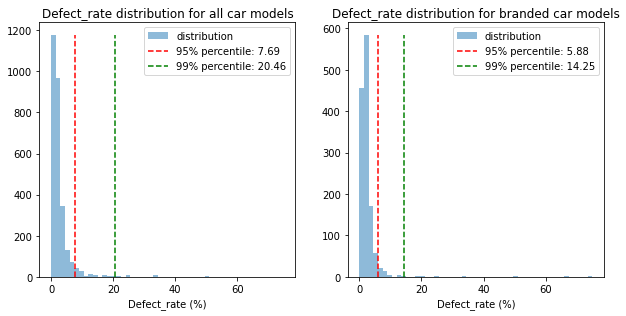

In [103]:
_, ax = plt.subplots(1, 2, figsize=(9, 4.5), tight_layout=True)

defect_rate_distr = (models['trips_defect_cnt']/models['trips_rated_cnt']*100).dropna()
bins = ax[0].hist(defect_rate_distr, bins=50, label='distribution', alpha=0.5)#.hist(bins=30)
ax[0].vlines(np.percentile(defect_rate_distr, 95), 0, max(bins[0]), 
           linestyles ="dashed", colors ="r", 
           label='95% percentile: {:.2f}'.format(np.percentile(defect_rate_distr, 95)))
ax[0].vlines(np.percentile(defect_rate_distr, 99), 0, max(bins[0]), 
           linestyles ="dashed", colors ="g", 
           label='99% percentile: {:.2f}'.format(np.percentile(defect_rate_distr, 99)))
ax[0].set_xlabel('Defect_rate (%)')
ax[0].legend()
ax[0].set_title('Defect_rate distribution for all car models')

defect_rate_distr = (models[models['can_be_branded']]['trips_defect_cnt']/models[
            models['can_be_branded']]['trips_rated_cnt']*100).dropna()
bins = ax[1].hist(defect_rate_distr, bins=50, label='distribution', alpha=0.5)#.hist(bins=30)
ax[1].vlines(np.percentile(defect_rate_distr, 95), 0, max(bins[0]), 
           linestyles ="dashed", colors ="r", 
           label='95% percentile: {:.2f}'.format(np.percentile(defect_rate_distr, 95)))
ax[1].vlines(np.percentile(defect_rate_distr, 99), 0, max(bins[0]), 
           linestyles ="dashed", colors ="g", 
           label='99% percentile: {:.2f}'.format(np.percentile(defect_rate_distr, 99)))
ax[1].set_xlabel('Defect_rate (%)')
ax[1].legend()
ax[1].set_title('Defect_rate distribution for branded car models')
plt.show()


In [104]:
branded = models[models['can_be_branded']]
current_defect_rate = (branded['trips_defect_cnt']/branded['trips_rated_cnt']).mean()*100
current_share_of_voice = branded['car_sticker_cnt'].sum()/models['car_cnt'].sum()*100
print('defect_rate for current classifier: {:.2f}%'.format(current_defect_rate))
print('share_of_voice for current classifier: {:.2f}%'.format(current_share_of_voice))

defect_rate for current classifier: 2.42%
share_of_voice for current classifier: 14.04%


In [6]:
models['defect_rate%'] = models['trips_defect_cnt']/models['trips_rated_cnt']*100

In [105]:
def count_share_of_voice(defect_rate, 
      motivation = models[models['can_be_branded']]['car_sticker_cnt'].sum()/models[
              models['can_be_branded']]['car_cnt'].sum(), unstick_olds=False):
    if unstick_olds:
        branded = models[models['defect_rate%'] < defect_rate]
        share_of_voice = branded['car_cnt'].sum() * motivation / models['car_cnt'].sum()*100
        return share_of_voice

    models['branded_tmp'] = (models['defect_rate%'] < defect_rate).astype(int)
    models['branded_tmp'] = (models['can_be_branded']).astype(int) + models['branded_tmp']
    branded = models[models['branded_tmp'] > 0]
    share_of_voice = branded['car_cnt'].sum() * motivation /models['car_cnt'].sum()*100
    return share_of_voice

motivation_level = models[models['can_be_branded']]['car_sticker_cnt'].sum()/models[
              models['can_be_branded']]['car_cnt'].sum()*100
print('Current motivation level: {:.2f}%'.format(motivation_level))    

Current motivation level: 17.77%


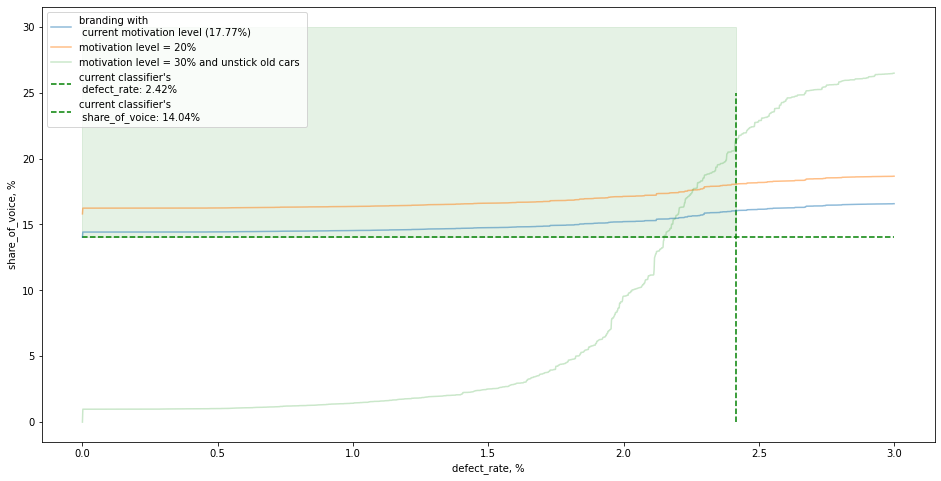

In [106]:
x = np.linspace(0, 3, 2000)
plt.figure(figsize=(16,8))
plt.plot(x, [count_share_of_voice(dr) for dr in x], 
         alpha=0.5, label='branding with \n current motivation level ({:.2f}%)'.format(
             motivation_level
         ))
plt.plot(x, [count_share_of_voice(dr, motivation=0.2) for dr in x], 
         alpha=0.5, label='motivation level = 20%')
plt.plot(x, [count_share_of_voice(dr, motivation=0.3, unstick_olds=True) for dr in x], 
         alpha=0.25, label='motivation level = 30% and unstick old cars '.format(
             motivation_level))
plt.vlines(current_defect_rate, 0, 25, 
           linestyles ="dashed", colors ="g", 
           label="current classifier's \n defect_rate: {:.2f}%".format(current_defect_rate))
plt.hlines(current_share_of_voice, 0, 3, 
           linestyles ="dashed", colors ="g", 
           label="current classifier's \n share_of_voice: {:.2f}%".format(current_share_of_voice))
plt.fill_between([0, current_defect_rate], 
                 current_share_of_voice, 30, color='g', alpha=0.1)
plt.xlabel('defect_rate, %')
plt.ylabel('share_of_voice, %')
plt.legend()
plt.show()

In [ ]:
partners.head(1)

,Unnamed: 0,partner,model,year,car_cnt,car_sticker_cnt
0,0,partner_6613,model_147,year_30,1,0


In [96]:
models['branded_tmp'] = list(models['defect_rate%'] < 2)
models['branded_tmp'] = models['branded_tmp'] | models['can_be_branded']

tmp1 = partners.groupby('partner').sum().reset_index()
tmp = tmp[tmp['car_cnt'] > tmp['car_sticker_cnt']]
tmp['left_to_stick'] = tmp['car_cnt'] - tmp['car_sticker_cnt']
tmp1= tmp[['partner', 'left_to_stick']] 

tmp2 = partners.merge(models,on=['model', 'year'], suffixes=('_ptn', '_mdl'))[
      ['partner','model','year', 'car_cnt_ptn', 
    'car_sticker_cnt_ptn', 'branded_tmp', 'defect_rate%', 'can_be_branded']]
tmp2['allowed_to_stick_now'] = tmp2['car_cnt_ptn'] - tmp2['car_sticker_cnt_ptn']
tmp2 = tmp2[tmp2['can_be_branded']].groupby('partner').sum()['allowed_to_stick_now'].reset_index()
tmp1 = tmp1.merge(tmp2, how='left')

tmp2 = partners.merge(models,on=['model', 'year'], suffixes=('_ptn', '_mdl'))[
      ['partner','model','year', 'car_cnt_ptn', 
    'car_sticker_cnt_ptn', 'branded_tmp', 'defect_rate%', 'can_be_branded']]
  
tmp2['allowed_to_stick_then'] = tmp2['car_cnt_ptn'] - tmp2['car_sticker_cnt_ptn']
tmp2 = tmp2[tmp2['branded_tmp']].groupby('partner').sum()['allowed_to_stick_then'].reset_index()
tmp1 = tmp1.merge(tmp2, how='left', on='partner')

tmp1 = tmp1.fillna(0)
tmp1['happiness_now'] = tmp1['allowed_to_stick_now']/tmp1['left_to_stick']
tmp1['happiness_then'] = tmp1['allowed_to_stick_then']/tmp1['left_to_stick']
print('mean happiness now: {:.2f}%'.format(tmp1['happiness_now'].mean()*100))
print('mean happiness then: {:.2f}%'.format(tmp1['happiness_then'].mean()*100))

mean happiness now: 76.77%
mean happiness then: 83.69%


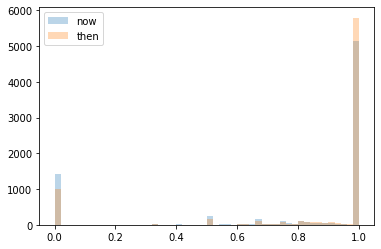

In [109]:
plt.hist(tmp1['happiness_now'], bins=50, alpha=0.3, label='mean happiness now: 76.77%')
plt.hist(tmp1['happiness_then'], bins=50, alpha=0.3, label='mean happiness then: 83.69%')
plt.legend()
plt.show()

In [110]:
from scipy.stats import wilcoxon
wilcoxon(tmp1['happiness_now'], tmp1['happiness_then'])

WilcoxonResult(statistic=0.0, pvalue=2.0436258313700874e-199)